<a href="https://colab.research.google.com/github/AdamClarkStandke/GenerativeDeepLearning/blob/main/Keras_Weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Textual Inversion With My Face:



In [1]:
!pip install -U tensorflow -q
!pip install keras-cv==0.6.0 -q
!pip install keras-core -q

import math
import string
import random
import keras_cv
import numpy as np
import tensorflow as tf
from keras_cv import layers as cv_layers
from keras_cv.models.stable_diffusion import NoiseScheduler
from tensorflow import keras
import matplotlib.pyplot as plt
from keras_core import ops
from PIL import Image

stable_diffusion = keras_cv.models.StableDiffusion()


def assemble_image_dataset(urls):
    # Fetch all remote files
    files = [tf.keras.utils.get_file(origin=url) for url in urls]

    # Resize images
    resize = keras.layers.Resizing(height=512, width=512, crop_to_aspect_ratio=True)
    images = [keras.utils.load_img(img) for img in files]
    images = [keras.utils.img_to_array(img) for img in images]
    images = np.array([resize(img) for img in images])

    # The StableDiffusion image encoder requires images to be normalized to the
    # [-1, 1] pixel value range
    images = images / 127.5 - 1

    # Create the tf.data.Dataset
    image_dataset = tf.data.Dataset.from_tensor_slices(images)

    # Shuffle and introduce random noise
    image_dataset = image_dataset.shuffle(50, reshuffle_each_iteration=True)
    image_dataset = image_dataset.map(
        cv_layers.RandomCropAndResize(
            target_size=(512, 512),
            crop_area_factor=(0.8, 1.0),
            aspect_ratio_factor=(1.0, 1.0),
        ),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    image_dataset = image_dataset.map(
        cv_layers.RandomFlip(mode="horizontal"),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    return image_dataset

MAX_PROMPT_LENGTH = 77
placeholder_token = "<my-sexy-face-token>"


def pad_embedding(embedding):
    return embedding + (
        [stable_diffusion.tokenizer.end_of_text] * (MAX_PROMPT_LENGTH - len(embedding))
    )


stable_diffusion.tokenizer.add_tokens(placeholder_token)


def assemble_text_dataset(prompts):
    prompts = [prompt.format(placeholder_token) for prompt in prompts]
    embeddings = [stable_diffusion.tokenizer.encode(prompt) for prompt in prompts]
    embeddings = [np.array(pad_embedding(embedding)) for embedding in embeddings]
    text_dataset = tf.data.Dataset.from_tensor_slices(embeddings)
    text_dataset = text_dataset.shuffle(100, reshuffle_each_iteration=True)
    return text_dataset

def assemble_dataset(urls, prompts):
    image_dataset = assemble_image_dataset(urls)
    text_dataset = assemble_text_dataset(prompts)
    # the image dataset is quite short, so we repeat it to match the length of the
    # text prompt dataset
    image_dataset = image_dataset.repeat()
    # we use the text prompt dataset to determine the length of the dataset.  Due to
    # the fact that there are relatively few prompts we repeat the dataset 5 times.
    # we have found that this anecdotally improves results.
    text_dataset = text_dataset.repeat(5)
    return tf.data.Dataset.zip((image_dataset, text_dataset))

single_ds = assemble_dataset(
    urls=[
        "https://i.imgur.com/xR6Jl5u.jpg",
        "https://i.imgur.com/Jm3A3Wg.jpg",
        "https://i.imgur.com/onznz55.jpg",
        "https://i.imgur.com/4Rf4MJB.jpg",
        "https://i.imgur.com/CSnJH7f.jpg",
    ],
    prompts=[
        "a photo of a {}",
        "a rendering of a {}",
        "a cropped photo of the {}",
        "the photo of a {}",
        "a photo of a clean {}",
        "a photo of my {}",
        "a photo of the cool {}",
        "a close-up photo of a {}",
        "a bright photo of the {}",
        "a cropped photo of a {}",
        "a photo of the {}",
        "a good photo of the {}",
        "a photo of one {}",
        "a close-up photo of the {}",
        "a rendition of the {}",
        "a photo of the clean {}",
        "a rendition of a {}",
        "a photo of a nice {}",
        "a good photo of a {}",
        "a photo of the nice {}",
        "a photo of the small {}",
        "a photo of the weird {}",
        "a photo of the large {}",
        "a photo of a cool {}",
        "a photo of a small {}",
    ],
)

group_ds = assemble_dataset(
    urls=[
        "https://i.imgur.com/bDCCWn6.png",
        "https://i.imgur.com/TUgHrJm.png",
        "https://i.imgur.com/283nK4Z.png",
    ],
    prompts=[
        "a photo of a group of {}",
        "a rendering of a group of {}",
        "a cropped photo of the group of {}",
        "the photo of a group of {}",
        "a photo of a clean group of {}",
        "a photo of my group of {}",
        "a photo of a cool group of {}",
        "a close-up photo of a group of {}",
        "a bright photo of the group of {}",
        "a cropped photo of a group of {}",
        "a photo of the group of {}",
        "a good photo of the group of {}",
        "a photo of one group of {}",
        "a close-up photo of the group of {}",
        "a rendition of the group of {}",
        "a photo of the clean group of {}",
        "a rendition of a group of {}",
        "a photo of a nice group of {}",
        "a good photo of a group of {}",
        "a photo of the nice group of {}",
        "a photo of the small group of {}",
        "a photo of the weird group of {}",
        "a photo of the large group of {}",
        "a photo of a cool group of {}",
        "a photo of a small group of {}",
    ],
)
train_ds = single_ds.concatenate(group_ds)
train_ds = train_ds.batch(1).shuffle(
    train_ds.cardinality(), reshuffle_each_iteration=True
)

tokenized_initializer = stable_diffusion.tokenizer.encode("face")[1]
new_weights = stable_diffusion.text_encoder.layers[2].token_embedding(
    tf.constant(tokenized_initializer)
)

# Get len of .vocab instead of tokenizer
new_vocab_size = len(stable_diffusion.tokenizer.vocab)

# The embedding layer is the 2nd layer in the text encoder
old_token_weights = stable_diffusion.text_encoder.layers[
    2
].token_embedding.get_weights()
old_position_weights = stable_diffusion.text_encoder.layers[
    2
].position_embedding.get_weights()

old_token_weights = old_token_weights[0]
new_weights = np.expand_dims(new_weights, axis=0)
new_weights = np.concatenate([old_token_weights, new_weights], axis=0)

# Have to set download_weights False so we can init (otherwise tries to load weights)
new_encoder = keras_cv.models.stable_diffusion.TextEncoder(
    keras_cv.models.stable_diffusion.stable_diffusion.MAX_PROMPT_LENGTH,
    vocab_size=new_vocab_size,
    download_weights=False,
)
for index, layer in enumerate(stable_diffusion.text_encoder.layers):
    # Layer 2 is the embedding layer, so we omit it from our weight-copying
    if index == 2:
        continue
    new_encoder.layers[index].set_weights(layer.get_weights())


new_encoder.layers[2].token_embedding.set_weights([new_weights])
new_encoder.layers[2].position_embedding.set_weights(old_position_weights)

stable_diffusion._text_encoder = new_encoder
stable_diffusion._text_encoder.compile(jit_compile=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.3/756.3 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 13.4 MB/s eta 0:00:00
Using TensorFlow backend
By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE
492466864/492466864 [==============================] - 3s 0us/step


# Main Application


100/100 [==============================] - 118s 1s/step


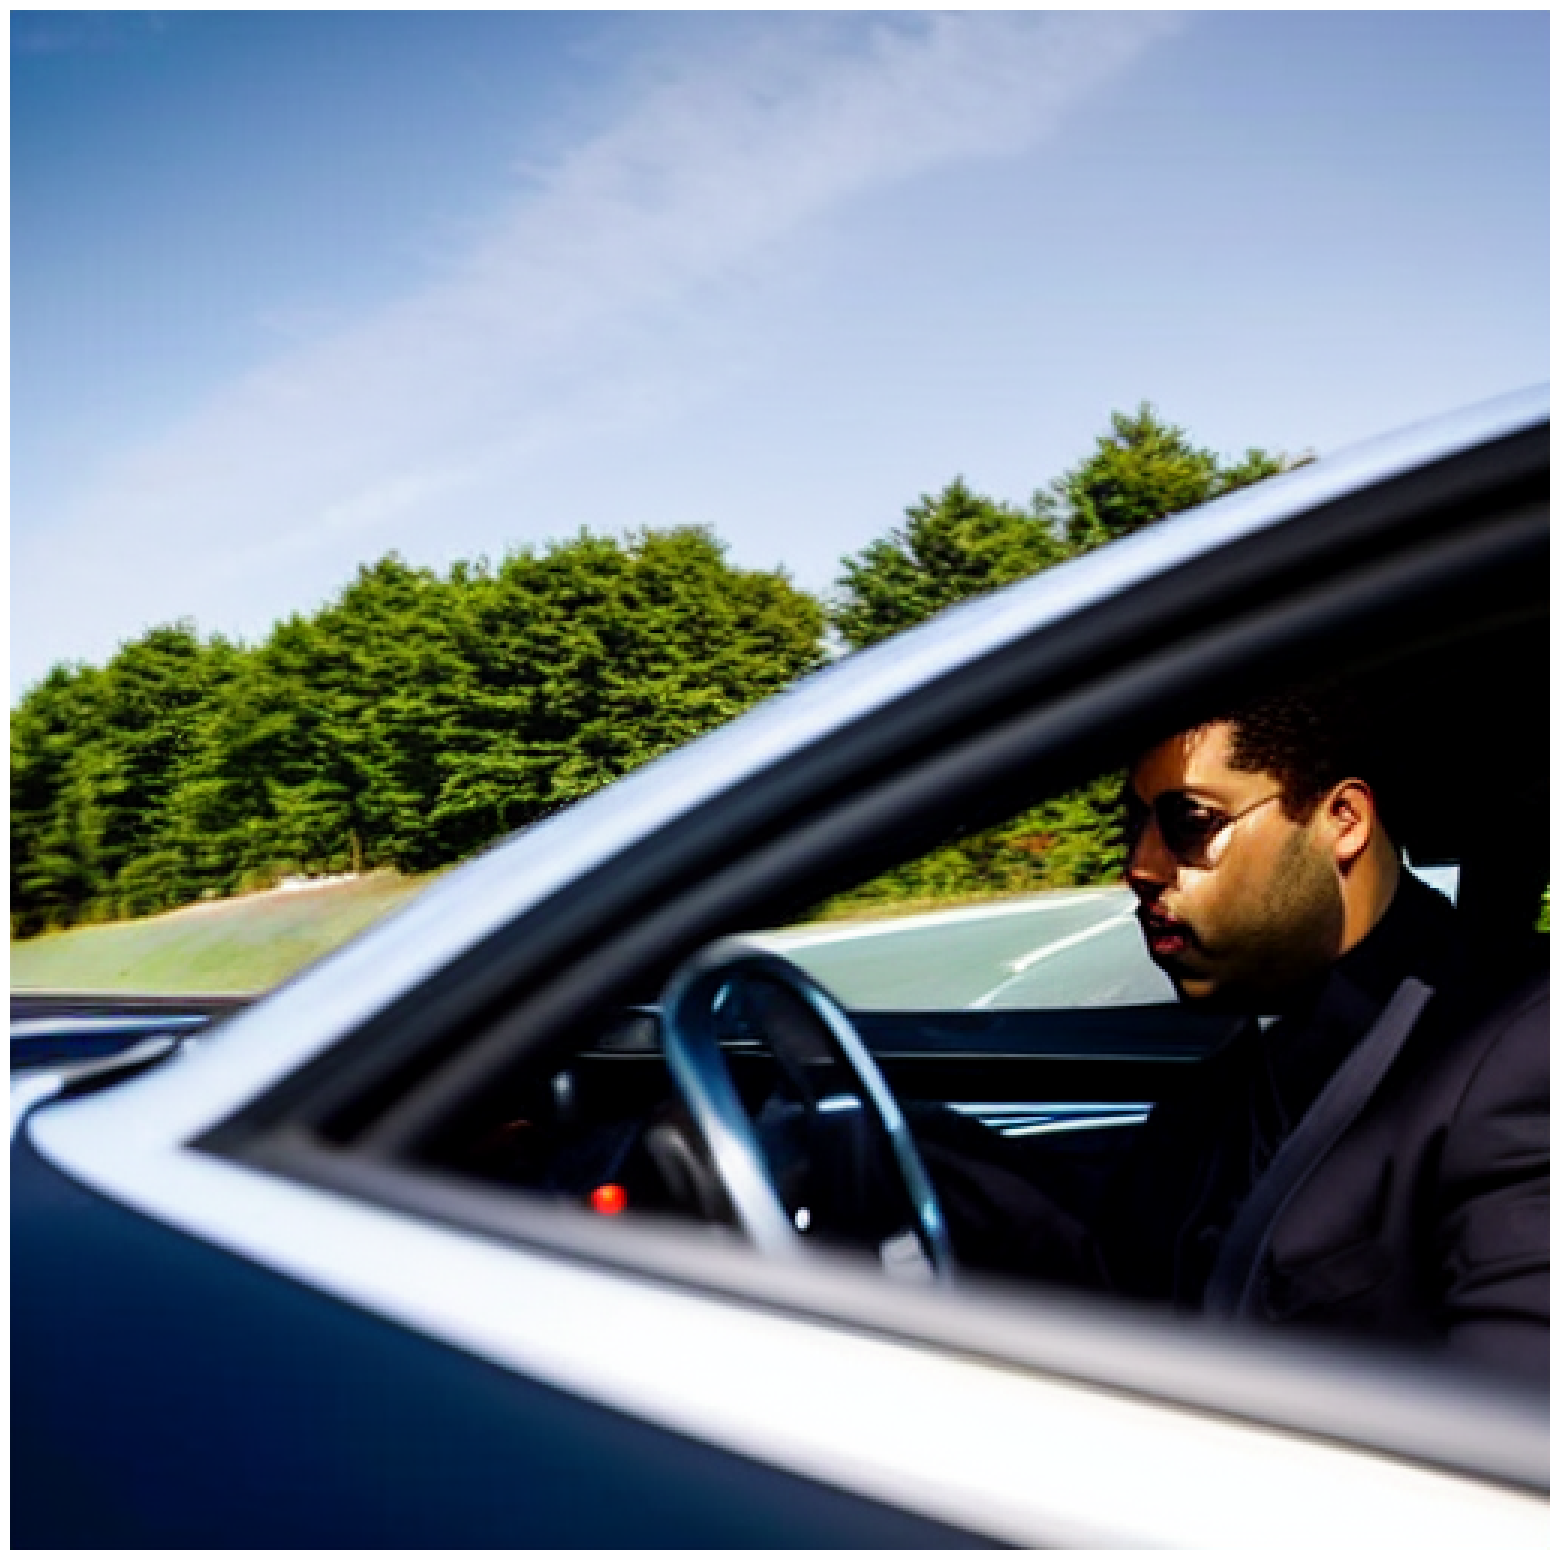

In [14]:
pretrained=np.load("/content/drive/MyDrive/pretrained.npy", allow_pickle=True)
stable_diffusion.text_encoder.layers[2].set_weights(pretrained)
prompt =  f"man  with {placeholder_token} in fancy suit driving ferrari on highway in Berlin, side view"
images = stable_diffusion.text_to_image(prompt=prompt,unconditional_guidance_scale=12, negative_prompt="ugly, deformed, disfigured, poor details, bad anatomy", num_steps=100, seed=42, batch_size=1)
def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.axis("off")
        plt.savefig("my_face.png")
        plt.imshow(images[i])
plot_images(images)